In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN,SMOTE
from scipy.stats import chi2_contingency,chi2
from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve,precision_recall_curve,classification_report
from sklearn.metrics import plot_roc_curve
from pycaret.classification import *
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_transformer
from eli5 import show_prediction,show_weights
from shap import TreeExplainer,summary_plot,dependence_plot,decision_plot
from plotnine import *
from sklearn.linear_model import LogisticRegression
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier,plot_tree
from catboost import CatBoostClassifier
from joblib import Parallel,delayed
import sweetviz as sv

In [23]:
os.chdir('/home/sadil/DS Dataset/Flu')
os.listdir()

['submission.csv',
 'cb_model.json',
 'build',
 'train.csv',
 'test.csv',
 'errortools.egg-info',
 'train_labels.csv',
 'catboost_info',
 'SWEETVIZ_REPORT.html',
 'dist']

In [24]:
train = pd.read_csv('train.csv')
label = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')
del train['hhs_geo_region']
del train['employment_industry']
del train['employment_occupation']
del train['census_msa']


del test['hhs_geo_region']
del test['employment_industry']
del test['employment_occupation']
del test['census_msa']
respon=test.pop('respondent_id')

In [25]:
train = train.merge(label, on=['respondent_id'])
del train['respondent_id']
del label
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

### Renaming Columns

In [26]:
train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,0.0,0.0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,2.0,0.0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,1.0,0.0,0,0


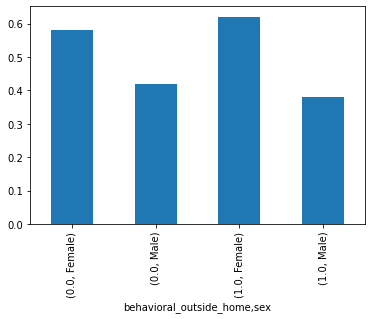

In [84]:
train.groupby(['behavioral_outside_home'])['sex'].value_counts(normalize=True).plot(kind='bar')

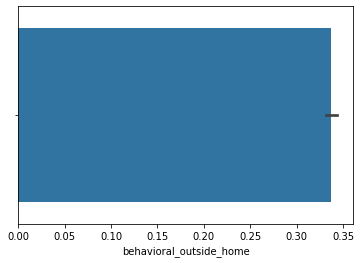

In [116]:
sns.barplot(x='behavioral_outside_home',data=train)

In [105]:
position_stack()

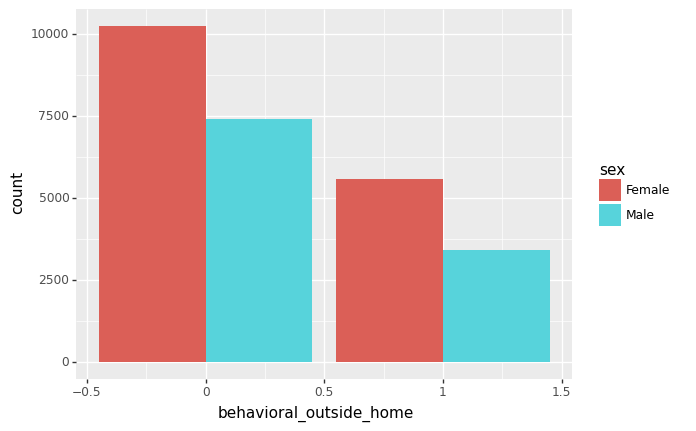

<ggplot: (8778470452625)>

In [115]:
(ggplot(aes(x='behavioral_outside_home',fill='sex'),data=train)+geom_bar(position='dodge'))

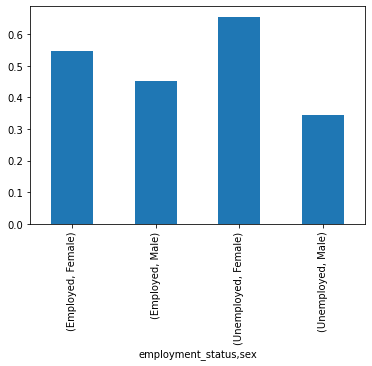

In [85]:
train.groupby(['employment_status'])['sex'].value_counts(normalize=True).plot(kind='bar')

# Approach
* Since this is a multiclass classification, all are attributes are not related for each of them, two dataset approach has been taken

## Renaming Columns

In [27]:
train['education']=train['education'].replace({
    'College Graduate': 'College',
    'Some College': 'College',
    '12 Years': 'Basic',
    '< 12 Years':'Basic'
})

train['income_poverty'] = train['income_poverty'].replace({
    'Below Poverty':
    'Low',
    '<= $75,000, Above Poverty':
    'Medium',
    '> $75,000':
    'High'
})

train['age_group'] = train['age_group'].replace({
    '18 - 34 Years': 'Adult',
    '35 - 44 Years': 'Adult',
    '45 - 54 Years':'Adult',
    '55 - 64 Years':'Old',
    '65+ Years':'Old'
})


train['opinion_h1n1_sick_from_vacc']=train['opinion_h1n1_sick_from_vacc'].replace({1.0:0,2.0:0,3.0:1,4.0:1,5.0:1})

test['education']=test['education'].replace({
    'College Graduate': 'College',
    'Some College': 'College',
    '12 Years': 'Basic',
    '< 12 Years':'Basic'
})

test['income_poverty'] = test['income_poverty'].replace({
    'Below Poverty':
    'Low',
    '<= $75,000, Above Poverty':
    'Medium',
    '> $75,000':
    'High'
})

test['age_group'] = test['age_group'].replace({
    '18 - 34 Years': 'Adult',
    '35 - 44 Years': 'Adult',
    '45 - 54 Years':'Adult',
    '55 - 64 Years':'Old',
    '65+ Years':'Old'
})

train['employment_status']=train['employment_status'].replace({'Not in Labor Force':'Unemployed'})
test['employment_status']=test['employment_status'].replace({'Not in Labor Force':'Unemployed'})

test['opinion_h1n1_sick_from_vacc']=test['opinion_h1n1_sick_from_vacc'].replace({1.0:0,2.0:0,3.0:1,4.0:1,5.0:1})

In [28]:
train_h1n1 = train.drop(columns=[
    'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'seasonal_vaccine',
    'opinion_seas_risk', 'opinion_seas_sick_from_vacc'
])
train_flu = train.drop(columns=[
    'h1n1_concern', 'h1n1_knowledge', 'h1n1_vaccine', 'doctor_recc_h1n1',
    'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc'
])

In [29]:
test_h1n1 = test.drop(columns=[
    'doctor_recc_seasonal', 'opinion_seas_vacc_effective',
    'opinion_seas_risk', 'opinion_seas_sick_from_vacc'
])
test_flu = test.drop(columns=[
    'h1n1_concern', 'h1n1_knowledge','doctor_recc_h1n1',
    'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc'
])

# Chi2 Test of Independence

In [30]:
def chi2_test(data,column,target):
    """Chi2 Independence Test"""
    stat,p,dof,expected=chi2_contingency(pd.crosstab(data[column],data[target]).values)
    if p>0.05:
        return column

In [ ]:
Parallel(n_jobs=6)(delayed(chi2_test)(train_h1n1,i,'h1n1_vaccine') for 
                   i in list(train_h1n1.drop(columns=['h1n1_vaccine']).columns))

In [ ]:
Parallel(n_jobs=6)(delayed(chi2_test)(train_flu,i,'seasonal_vaccine') for 
                   i in list(train_flu.drop(columns=['seasonal_vaccine']).columns))

In [31]:
train_h1n1.drop(columns=['household_children','opinion_h1n1_sick_from_vacc','employment_status'],inplace=True)
test_h1n1.drop(columns=['household_children','opinion_h1n1_sick_from_vacc','employment_status'],inplace=True)

train_flu.drop(columns=['behavioral_antiviral_meds','child_under_6_months'],inplace=True)
test_flu.drop(columns=['behavioral_antiviral_meds','child_under_6_months'],inplace=True)

In [32]:
"""report_h1n1=sv.analyze(train_h1n1,target_feat='h1n1_vaccine')

report_h1n1.show_html()"""

"report_h1n1=sv.analyze(train_h1n1,target_feat='h1n1_vaccine')\n\nreport_h1n1.show_html()"

# Model on H1N1

In [33]:
object_cols_h1n1=list(train_h1n1.select_dtypes(['object']).columns)
numeric_col_h1n1=list(set(train_h1n1.columns)-set(object_cols_h1n1)-{'h1n1_vaccine'})

In [34]:
h1n1_setup = setup(train_h1n1,
                   target='h1n1_vaccine',
                   train_size=0.8,
                   numeric_features=numeric_col_h1n1,
                  categorical_imputation='mode',sampling=False)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,5586
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(26707, 25)"
4,Missing Values,True
5,Numeric Features,17
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [35]:
x_train,y_train,x_test,y_test=h1n1_setup[2],h1n1_setup[4],h1n1_setup[3],h1n1_setup[5]
del h1n1_setup
test_h1n1['h1n1_vaccine']=[0]*(len(test_h1n1)//2)+[1]*(len(test_h1n1)//2)

h1n1_setup = setup(test_h1n1,
                   target='h1n1_vaccine',
                   categorical_imputation='mode',sampling=False)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,1672
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(26708, 25)"
4,Missing Values,True
5,Numeric Features,0
6,Categorical Features,24
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [36]:
test_h1n1=h1n1_setup[0]

test_h1n1.columns=x_train.columns

## XgBoost

In [23]:
ada=ADASYN()
x_train_resampled,y_train_resampled=ada.fit_resample(x_train,y_train)

In [55]:
x_train.drop(columns=['race_Hispanic','race_White'],inplace=True)
x_test.drop(columns=['race_Hispanic','race_White'],inplace=True)

In [75]:
xgb=XGBClassifier(learning_rate=0.4,verbose=False)
xgb=xgb.fit(x_train,y_train)

In [76]:
roc_auc_score(y_train,xgb.predict_proba(x_train)[:,1])

0.8808359564388637

In [77]:
roc_auc_score(y_test,xgb.predict_proba(x_test)[:,1])

0.8533074202948934

In [78]:
print(classification_report(y_test,xgb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4207
           1       0.72      0.50      0.59      1135

    accuracy                           0.85      5342
   macro avg       0.80      0.73      0.75      5342
weighted avg       0.84      0.85      0.84      5342



In [79]:
cross_val = cross_validate(xgb, x_train, y_train, scoring='roc_auc')
print(
    f"Mean {cross_val['test_score'].mean()}, Standard Deviation {cross_val['test_score'].std()}"
)

Mean 0.8576270044367256, Standard Deviation 0.009889804142986016


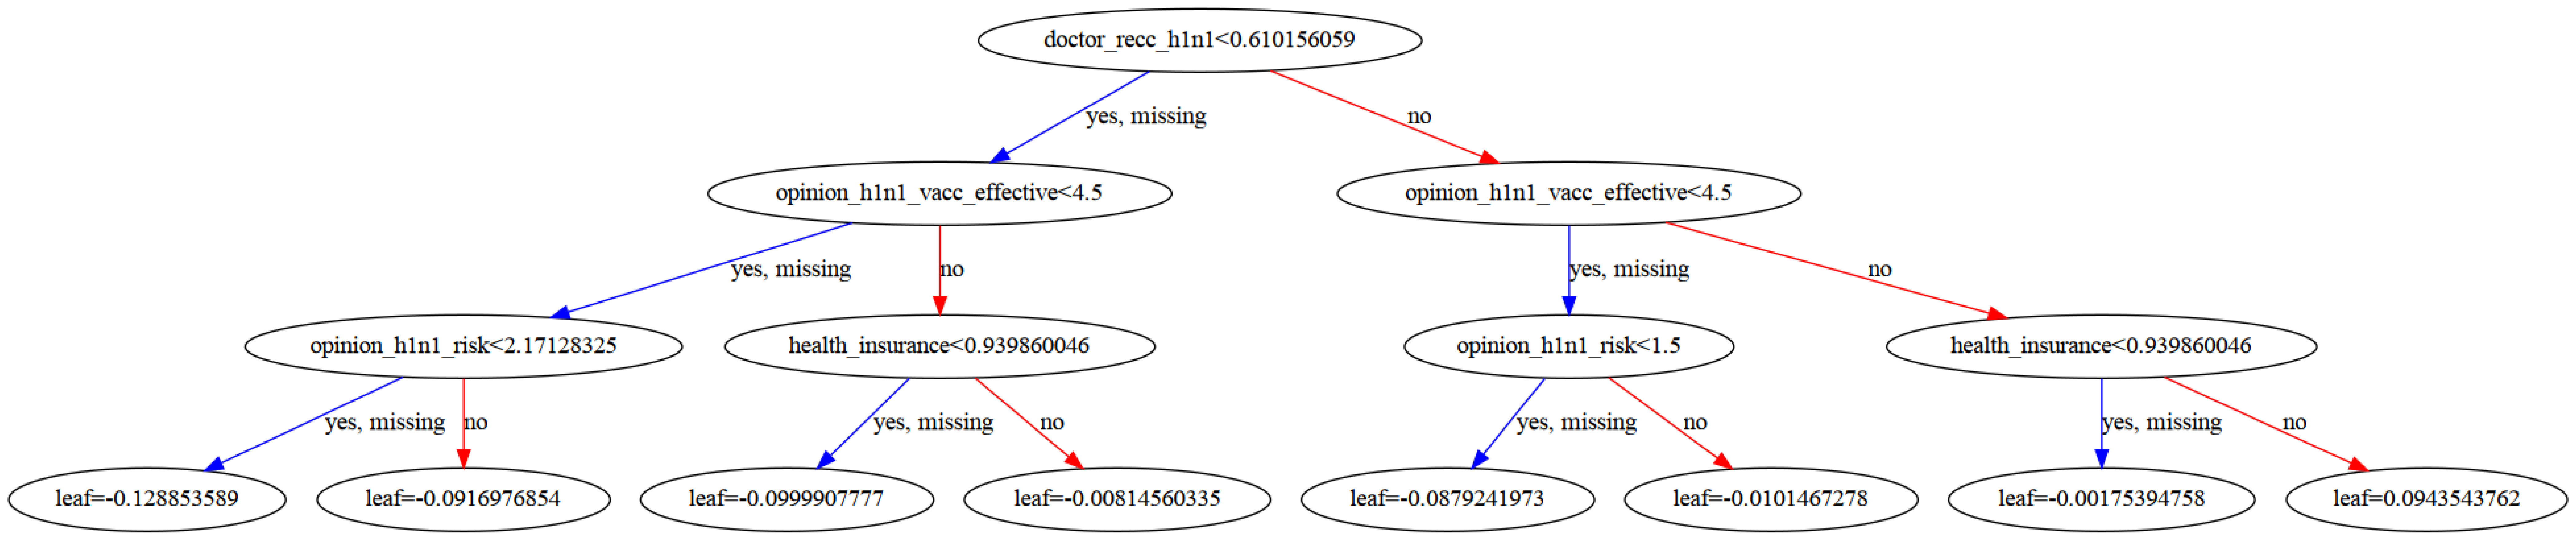

In [48]:
# Plotting a Tree
plot_tree(xgb,num_trees=4)
fig = plt.gcf()
fig.set_size_inches(150,100)

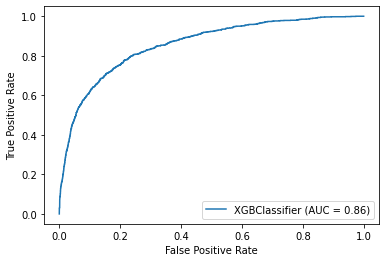

In [49]:
plot_roc_curve(xgb,x_test,y_test)

In [50]:
test_pred_h1n1=xgb.predict_proba(test_h1n1)[:,1]

test_pred_h1n1=pd.DataFrame({'respondent_id':respon,
                            'h1n1_vaccine':test_pred_h1n1})

# Shap Interpretation

In [52]:
x_train['health_insurance'].value_counts()

1.00000    10136
0.87972     9857
0.00000     1372
Name: health_insurance, dtype: int64

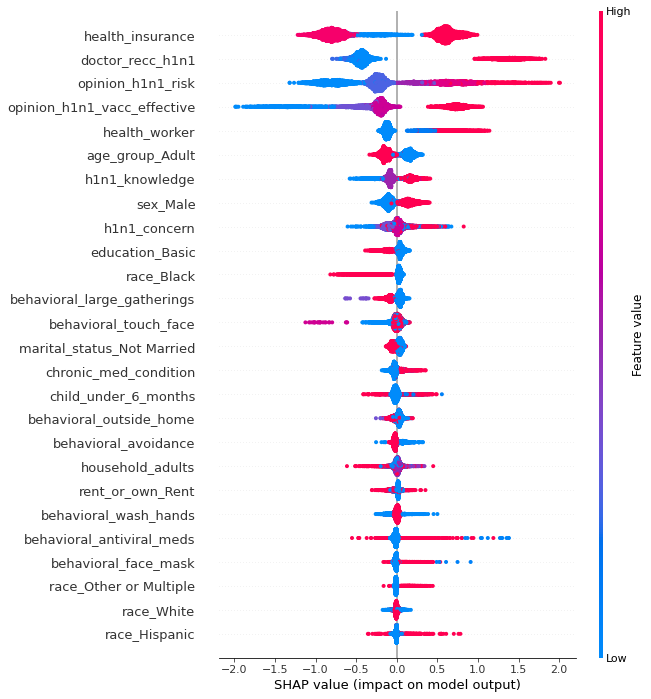

In [80]:
shap_val=TreeExplainer(xgb).shap_values(x_test.iloc[:10000])

summary_plot(shap_val,x_test.iloc[:10000],plot_type='dot',max_display=100)

# Model on Seasonal Flu

In [123]:
object_cols_flu=list(train_flu.select_dtypes(['object']).columns)
numeric_col_flu=list(set(train_flu.columns)-set(object_cols_flu)-{'seasonal_vaccine'})

In [124]:
flu_setup = setup(train_flu,
                   target='seasonal_vaccine',
                   train_size=0.85,
                  categorical_imputation='mode',sampling=False)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,8837
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(26707, 24)"
4,Missing Values,True
5,Numeric Features,0
6,Categorical Features,23
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [125]:
x_train_flu,y_train_flu,x_test_flu,y_test_flu=flu_setup[2],flu_setup[4],flu_setup[3],flu_setup[5]
del flu_setup
test_flu['seasonal_vaccine']=[0]*(len(test_flu)//2)+[1]*(len(test_flu)//2)

flu_setup = setup(test_flu,
                   target='seasonal_vaccine',
                   categorical_imputation='mode',sampling=False)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2227
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(26708, 24)"
4,Missing Values,True
5,Numeric Features,0
6,Categorical Features,23
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [126]:
test_flu=flu_setup[0]

test_flu.columns = x_train_flu.columns

In [127]:
set(test_flu.columns)-set(x_train_flu.columns)

set()

## Xgboost

In [128]:
column=['race_Black', 'race_Hispanic',
       'race_Other or Multiple', 'race_White', 'sex_Male']

In [129]:
sm=SMOTE()
x_train_flu_resampled,y_train_flu_resampled=sm.fit_resample(x_train_flu,y_train_flu)

In [130]:
xgb_flu=XGBClassifier()
xgb_flu=xgb_flu.fit(x_train_flu,y_train_flu)

In [131]:
roc_auc_score(y_train_flu,xgb_flu.predict_proba(x_train_flu)[:,1])

0.8584174204677438

In [132]:
roc_auc_score(y_test_flu,xgb_flu.predict_proba(x_test_flu)[:,1])

0.8560125813933347

In [133]:
cross_val_flu = cross_validate(xgb_flu, x_train_flu, y_train_flu, scoring='roc_auc')
print(
    f"Mean {cross_val_flu['test_score'].mean()}, Standard Deviation {cross_val_flu['test_score'].std()}"
)

Mean 0.8523314929013066, Standard Deviation 0.002884745401596469


In [134]:
test_pred_flu=xgb_flu.predict_proba(test_flu)[:,1]

test_pred_flu=pd.DataFrame({'respondent_id':respon,
                            'seasonal_vaccine':test_pred_flu})

# Shap Interpretation

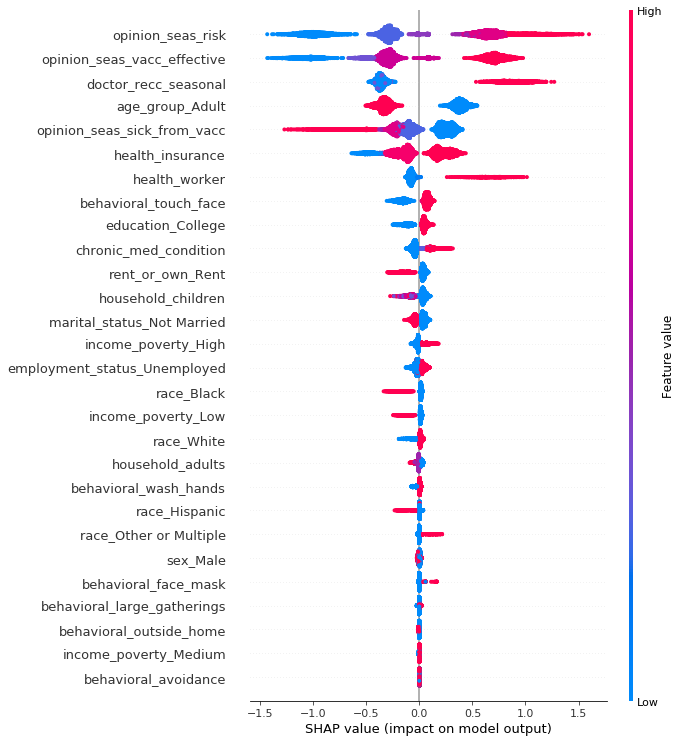

In [135]:
shap_val=TreeExplainer(xgb_flu).shap_values(x_train_flu.iloc[:10000])

summary_plot(shap_val,x_train_flu.iloc[:10000],plot_type='dot',max_display=100)

# Submission

In [136]:
submission=pd.merge(test_pred_h1n1,test_pred_flu,on=['respondent_id'])

In [137]:
submission.to_csv('submission.csv',index=False)